In [6]:
# Import libraries
import pandas as pd
import xgboost as xgb
import time
import numpy as ny
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [7]:
# Load the dataset
data = pd.read_csv('https://github.com/edeliciouso/Predicting-Yields-for-Potatoes/blob/main/MergedDataFinal4.csv?raw=true')
data = data.drop(['Year','Item'], axis = 1)
data

,Country,Yield (100 hg/ha),Pesticides (Tons),Rainfall (mm),Fertilizer (kg/ha)
0,Albania,55693,410.55,1485.0,79.08
1,Albania,66790,590.50,1485.0,76.47
2,Albania,59869,582.68,1485.0,87.08
3,Albania,67290,361.62,1485.0,82.79
4,Albania,69533,450.60,1485.0,78.15
...,...,...,...,...,...
1194,Zimbabwe,5803,2185.07,657.0,19.17
1195,Zimbabwe,4405,2185.07,657.0,31.78
1196,Zimbabwe,13933,2185.07,657.0,35.71
1197,Zimbabwe,13506,2185.07,657.0,32.39


In [8]:
# Select features (X) and target variable (y)
features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)', 'Country']
target = 'Yield (100 hg/ha)'

x = data[features]
y = data[target]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [9]:
# Create transformers for numeric and categorical features
numeric_features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)']
categorical_features = ['Country']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline with scaling, one-hot encoding, and XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb_reg', xgb.XGBRegressor())
])

# Define the hyperparameter grid for XGBoost
param_grid = {
    'xgb_reg__max_depth': [3, 5, 7, 10],
    'xgb_reg__n_estimators': [50, 100, 150, 200],
    'xgb_reg__learning_rate': [0.01, 0.1, 0.2, 0.3]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pesticides '
                                                                          '(Tons)',
                                                                          'Rainfall '
                                                                          '(mm)',
                                                                          'Fertilizer '
                                                                          '(kg/ha)']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['Country'])])),
                                       ('xgb_reg',
                                        XGBRegressor(base_score=Non...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb_reg__learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'xgb_reg__max_depth': [3, 5, 7, 10],
                         'xgb_reg__n_estimators': [50, 100, 150, 200]},
             scoring='neg_mean_squared_error')

In [10]:
# Get the best model
best_model = grid_search.best_estimator_

# Train the XGBoost model
start_train_time = time.time()
best_model.fit(x_train, y_train)
end_train_time = time.time()

# Make predictions
start_pred_time = time.time()
y_pred = best_model.predict(x_test)
end_pred_time = time.time()

# Find the time taken
training_time = end_train_time - start_train_time
prediction_time = end_pred_time - start_pred_time

In [11]:
# Evaluate the model
r2 = r2_score(y_test, y_pred) # R^2
mae = mean_absolute_error(y_test, y_pred) # mean absolute error
mse = mean_squared_error(y_test, y_pred) # mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False) # root mean squared error
max_err = max_error(y_test, y_pred) # max error
mape = mean_absolute_percentage_error(y_test, y_pred) # mean absolute percentage error

print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Max Error: {max_err:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

print(f"Training Time: {training_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.5f} seconds")

R-squared (R2): 0.85
Mean Absolute Error (MAE): 7529.87
Mean Squared Error (MSE): 169546171.63
Root Mean Squared Error (RMSE): 13020.99
Max Error: 95282.46
Mean Absolute Percentage Error (MAPE): 0.20%
Training Time: 0.09 seconds
Prediction Time: 0.00887 seconds


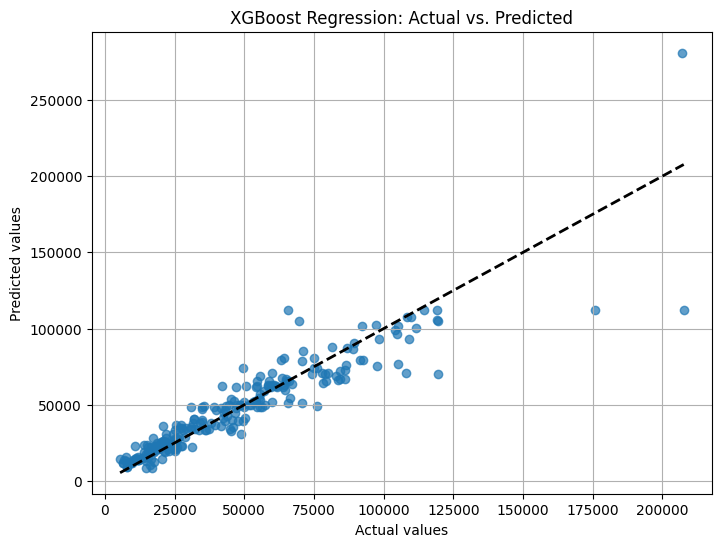

In [12]:
# Visualize predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('XGBoost Regression: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.grid(True)
plt.show()

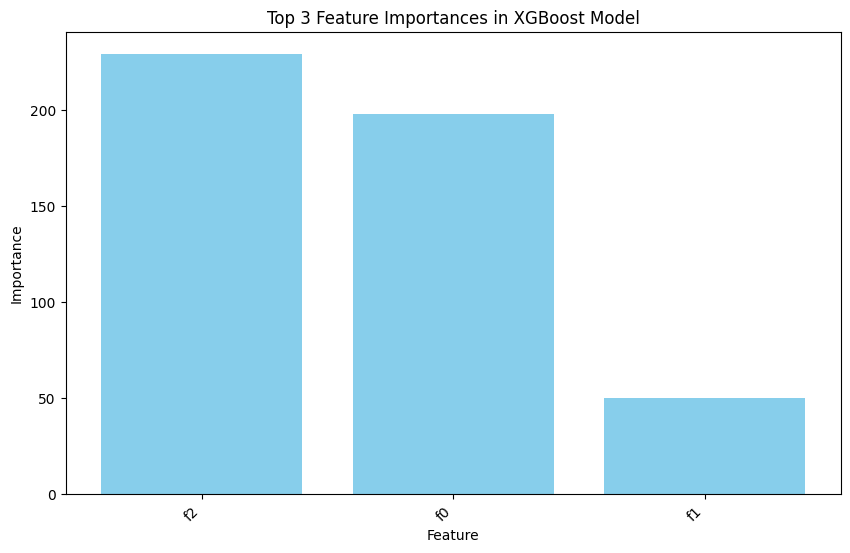

In [15]:
import matplotlib.pyplot as plt

# Extract feature importance
feature_importance = best_model.named_steps['xgb_reg'].get_booster().get_score(importance_type='weight')

# Sort features by importance in descending order
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Select top 3 features
top_features = sorted_features[:3]

# Extract feature names and importance scores
feature_names, importance_scores = zip(*top_features)

# Plotting the top 3 features
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importance_scores, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 3 Feature Importances in XGBoost Model')
plt.xticks(rotation=45, ha='right')
plt.show()